# 03_titanic_feature_selection
Autor: Carlos Wong <br/>
Fecha: 2022_06_11 <br/>
Tipo de problema: CLASIFICACIÓN <br/>
Entradas: 'train' kaggle competition (titanic) <br/>
Salidas: Submission ('PassengerId','Survived')  <br/>
Propósito: Práctica de análisis, visualización, entrenamiento, predicción y documentación
1. `Librerías + Descarga de datos <-------- `
2. Exploración de la variable objetivo
3. EDA (Exploración de datos)
4. Feature Engineering (Transformación de variables)
5. `Selección de variables <-------- `
6. Modelos (pipeline, semilla en train_test split y modelos, comparación modelos)
7. Métricas de evaluación
8. Selección de algoritmo
9. Parametrización de algoritmo
10. Guardado del modelo

## 1. LIBRERÍAS Y EXTRACCIÓN DE DATOS 

In [99]:
# librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
import warnings
warnings.filterwarnings("ignore")

In [101]:
# librerías sklearn
import sklearn
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [102]:
# librerías de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [103]:
# extracción de datasets
train = pd.read_csv(r'./output/FeatEngin_train_20220611_1.csv')
train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,0,3.0,male,22.0,1.0,0.0,7.2500,S,Mr,0
1,1,1.0,female,38.0,1.0,0.0,71.2833,C,Mrs,1


In [104]:
X = train.drop(['Survived'], axis=1)
y = train.Survived

In [105]:
traincolumns = X.columns.tolist()
print(traincolumns)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']


In [106]:
X.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,3.0,male,22.0,1.0,0.0,7.2500,S,Mr,0
1,1.0,female,38.0,1.0,0.0,71.2833,C,Mrs,1
2,3.0,female,26.0,0.0,0.0,7.9250,S,Miss,0


## 4. Feature Selection

Sólo se <b>eliminan</b> las siguientes variables:

- `SexMale` - muy alta correlación (87%) con `Title_Mister`;
- `hasCabin` - alta correlación (73%) con `Pclass`; <br/>

(`Title_Mister` y `Pclass` no se eliminan por ser más predictoras de la variable objetivo)

Resultados:

1. <b>SelectKBest - Chi2:</b> Mejores: Mr, Mrs, Miss, Pclass | Peor: Embarqued Q 
2. <b>LogisticRegression - MinMaxScaler - SelectKBest - Chi2:</b> Mayor accuracy: con 11 variables
3. <b>DecisionTree:</b> Mejores: Age, Fare, Mr, Pclass | Peor: Title_Other
4. <b>ExtraTreeClassifier:</b> Mejores: Age, Fare, Mr, Pclass | Peor: Title_Other
5. <b>LogisticRegression - MinMaxScaler:</b> Mejores: Mr, Pclass, Title_Other | Peor: Mrs

In [107]:
# Paso 1: Transformación de variables: a valores numéricos entre 0 y 1
# Se elimina una columna de cada variable transformada para evitar multicolinearidad
transformer = ColumnTransformer([
    ("encod1", OneHotEncoder(drop='if_binary'),['Sex']),
    ("encod2", OneHotEncoder(drop='first'), ['Embarked', 'Title']),
    ("minmax1", MinMaxScaler(), ['Fare','Age'])
],remainder='passthrough')
coltransform = transformer.fit_transform(X)

X = pd.DataFrame(coltransform, columns=transformer.get_feature_names_out().tolist())
X.head(3)

,encod1__Sex_male,encod2__Embarked_Q,encod2__Embarked_S,encod2__Title_Miss,encod2__Title_Mr,encod2__Title_Mrs,encod2__Title_Other,minmax1__Fare,minmax1__Age,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__hasCabin
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.014151,0.271174,3.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.139136,0.472229,1.0,1.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.015469,0.321438,3.0,0.0,0.0,0.0


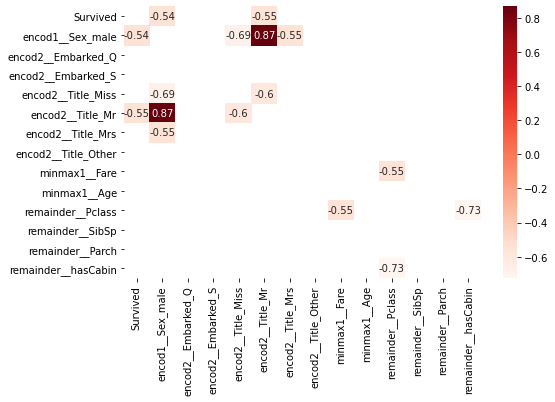

In [108]:
# Se muestra la matriz de correlaciones (que incluye variable objetivo) con las
# correlaciones que superan el (+/-) 50%
Xcorr = pd.concat([y, X], axis=1).corr()
filteredX = Xcorr[((Xcorr >= .5) | (Xcorr <= -.5)) & (Xcorr !=1.000)]
plt.figure(figsize=(8,5))
sns.heatmap(filteredX, annot=True, cmap="Reds")
plt.show()

In [128]:
print(X.columns.tolist())

['encod2__Embarked_Q', 'encod2__Embarked_S', 'encod2__Title_Miss', 'encod2__Title_Mr', 'encod2__Title_Mrs', 'encod2__Title_Other', 'minmax1__Fare', 'minmax1__Age', 'remainder__Pclass', 'remainder__SibSp', 'remainder__Parch']


In [110]:
# Se eliminan las variables que tienen un nivel de correlación superior al 70%
X.drop(['encod1__Sex_male','remainder__hasCabin'], 1, inplace=True)

### 4.1. SelectKBest - Chi2

In [130]:
# Selección del criterio de evaluación
criteria = SelectKBest(score_func=chi2, k=4)   # <-----------
results = criteria.fit(X, y)   # transformador   <-----------

In [113]:
aux = list(zip(results.pvalues_, results.scores_, X.columns))
pd_results = pd.DataFrame(aux, columns = ['p-valor','score','feature'])
pd_results.sort_values('score', ascending=False)

,p-valor,score,feature
3,2.379805e-26,112.805785,encod2__Title_Mr
4,6.380801e-21,88.050392,encod2__Title_Mrs
2,3.051887e-18,75.855581,encod2__Title_Miss
8,2.753786e-08,30.873699,remainder__Pclass
10,1.239091e-04,14.732242,remainder__Parch
6,2.980820e-03,8.819172,minmax1__Fare
9,4.276376e-03,8.162569,remainder__SibSp
1,1.913424e-02,5.489205,encod2__Embarked_S
5,5.172730e-01,0.419327,encod2__Title_Other
7,6.145086e-01,0.253662,minmax1__Age


### 4.2. LogisticRegression - MinMaxScaler - SelectKBest - Chi2

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99)

scaler = MinMaxScaler()   
algorithm = LogisticRegression (random_state=99) 

for i in range(4,12):  # <-------------
    selector = SelectKBest(score_func=chi2, k=i) 
    
    pipeline = make_pipeline(scaler,selector,algorithm)
    pipeline.fit(X_train, y_train)
    results = pipeline.score(X_test, y_test)  # Se saca el resultado con el conjunto test

    print(str(i) + ', accuracy = '+ str(results))

4, accuracy = 0.7443946188340808
5, accuracy = 0.7443946188340808
6, accuracy = 0.7443946188340808
7, accuracy = 0.7354260089686099
8, accuracy = 0.7354260089686099
9, accuracy = 0.7668161434977578
10, accuracy = 0.7802690582959642
11, accuracy = 0.7757847533632287


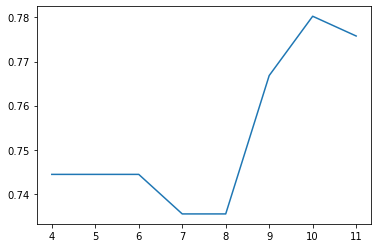

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99)

scaler = MinMaxScaler()   
algorithm = LogisticRegression (random_state=99) 

accuracies = []  # 
n_features = []  # 

for i in range(4,12):
    selector = SelectKBest(score_func=chi2, k=i) 
    
    pipeline = make_pipeline(scaler,selector,algorithm)
    pipeline.fit(X_train, y_train)
    results = pipeline.score(X_test, y_test)

    n_features.append(i)  # <-------------
    accuracies.append(results)  # <-------------

plt.plot(n_features, accuracies)
plt.show()

### 4.3. DecisionTree

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
results = model.score(X_test, y_test)
print(results)

0.8161434977578476


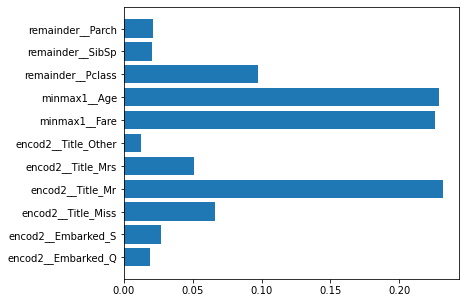

In [124]:
plt.figure(figsize=(6,5))
plt.barh(y=X.columns, width=model.feature_importances_)
plt.show()

### 4.4. ExtraTreeClassifier

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99)

model = ExtraTreesClassifier()
model.fit(X_train, y_train)
results = model.score(X_test, y_test)
print(results)

0.8026905829596412


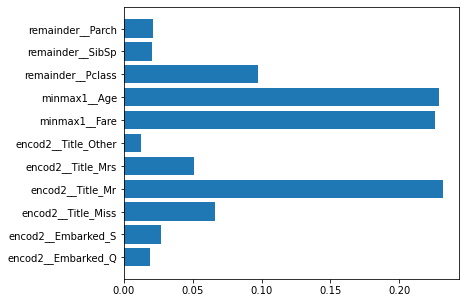

In [125]:
plt.figure(figsize=(6,5))
plt.barh(y=X.columns, width=model.feature_importances_)
plt.show()

### 4.5. LogisticRegression - MinMaxScaler

0.7757847533632287


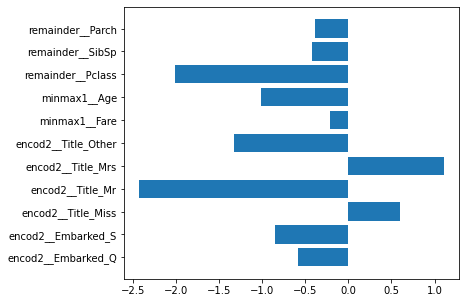

In [126]:
algorithm = LogisticRegression (random_state=99) 
scaler = MinMaxScaler()  # reescala los valores entre 0 y 1 
pipeline = make_pipeline(scaler, algorithm)

pipeline.fit(X_train,y_train)  # entrenamiemiento
print(pipeline.score(X_test,y_test))

plt.figure(figsize=(6,5))

# !!!! los coeficientes '.coef_' NO se pueden preguntar al pipeline, sino al algoritmo !!!!
# Se pueden sacar los '.coef_' porque el LogisticRegression tiene como atributo ese valor
# 'plt.barh' hace un plot de barras horizontal
# Se muestran los coeficientes normalizados
# Que salgan valores (+) o (-) significan que están correlacionados positiva o negativamente
# Se puede observar que la variable 'concave points_worst' está definida como más predictora por 2 algoritmos
plt.barh(y=X_train.columns, width=algorithm.coef_[0])
plt.show()

In [115]:
# Para guardar el train después del feature engineering
#train = pd.concat([train['Survived'], X], axis=1)
#train.to_csv('./output/FeatSelect_train_20220613_1.csv', index = False)